In [14]:
# Importing the libraries
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch

In [15]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder('/kaggle/input/data-set2/data_2', transform=transform)
print(len(full_dataset))

1200


In [16]:
test_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - test_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [17]:
resnet = models.resnet18(pretrained=False)

num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 20)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


device(type='cpu')

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [23]:
epochs = 10

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Test loop
    resnet.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Loss: {test_loss/len(test_loader)}, Accuracy: {100 * correct / total}%')

Epoch 1/10, Loss: 0.217196657260259
Test Loss: 1.6396003663539886, Accuracy: 58.333333333333336%
Epoch 2/10, Loss: 0.20915916860103606
Test Loss: 1.5584168583154678, Accuracy: 57.083333333333336%
Epoch 3/10, Loss: 0.17103905330101649
Test Loss: 1.6790852397680283, Accuracy: 54.583333333333336%
Epoch 4/10, Loss: 0.17922891279061634
Test Loss: 1.6240616738796234, Accuracy: 57.5%
Epoch 5/10, Loss: 0.12621893286705016
Test Loss: 1.6142890900373459, Accuracy: 58.75%
Epoch 6/10, Loss: 0.1386002575357755
Test Loss: 1.554187685251236, Accuracy: 59.583333333333336%
Epoch 7/10, Loss: 0.11181038071711859
Test Loss: 1.5598301440477371, Accuracy: 62.083333333333336%
Epoch 8/10, Loss: 0.0942105816056331
Test Loss: 1.5554691702127457, Accuracy: 60.416666666666664%
Epoch 9/10, Loss: 0.08103429848949115
Test Loss: 1.6050233095884323, Accuracy: 59.583333333333336%
Epoch 10/10, Loss: 0.07090144865214824
Test Loss: 1.5134870260953903, Accuracy: 62.916666666666664%


Analysis

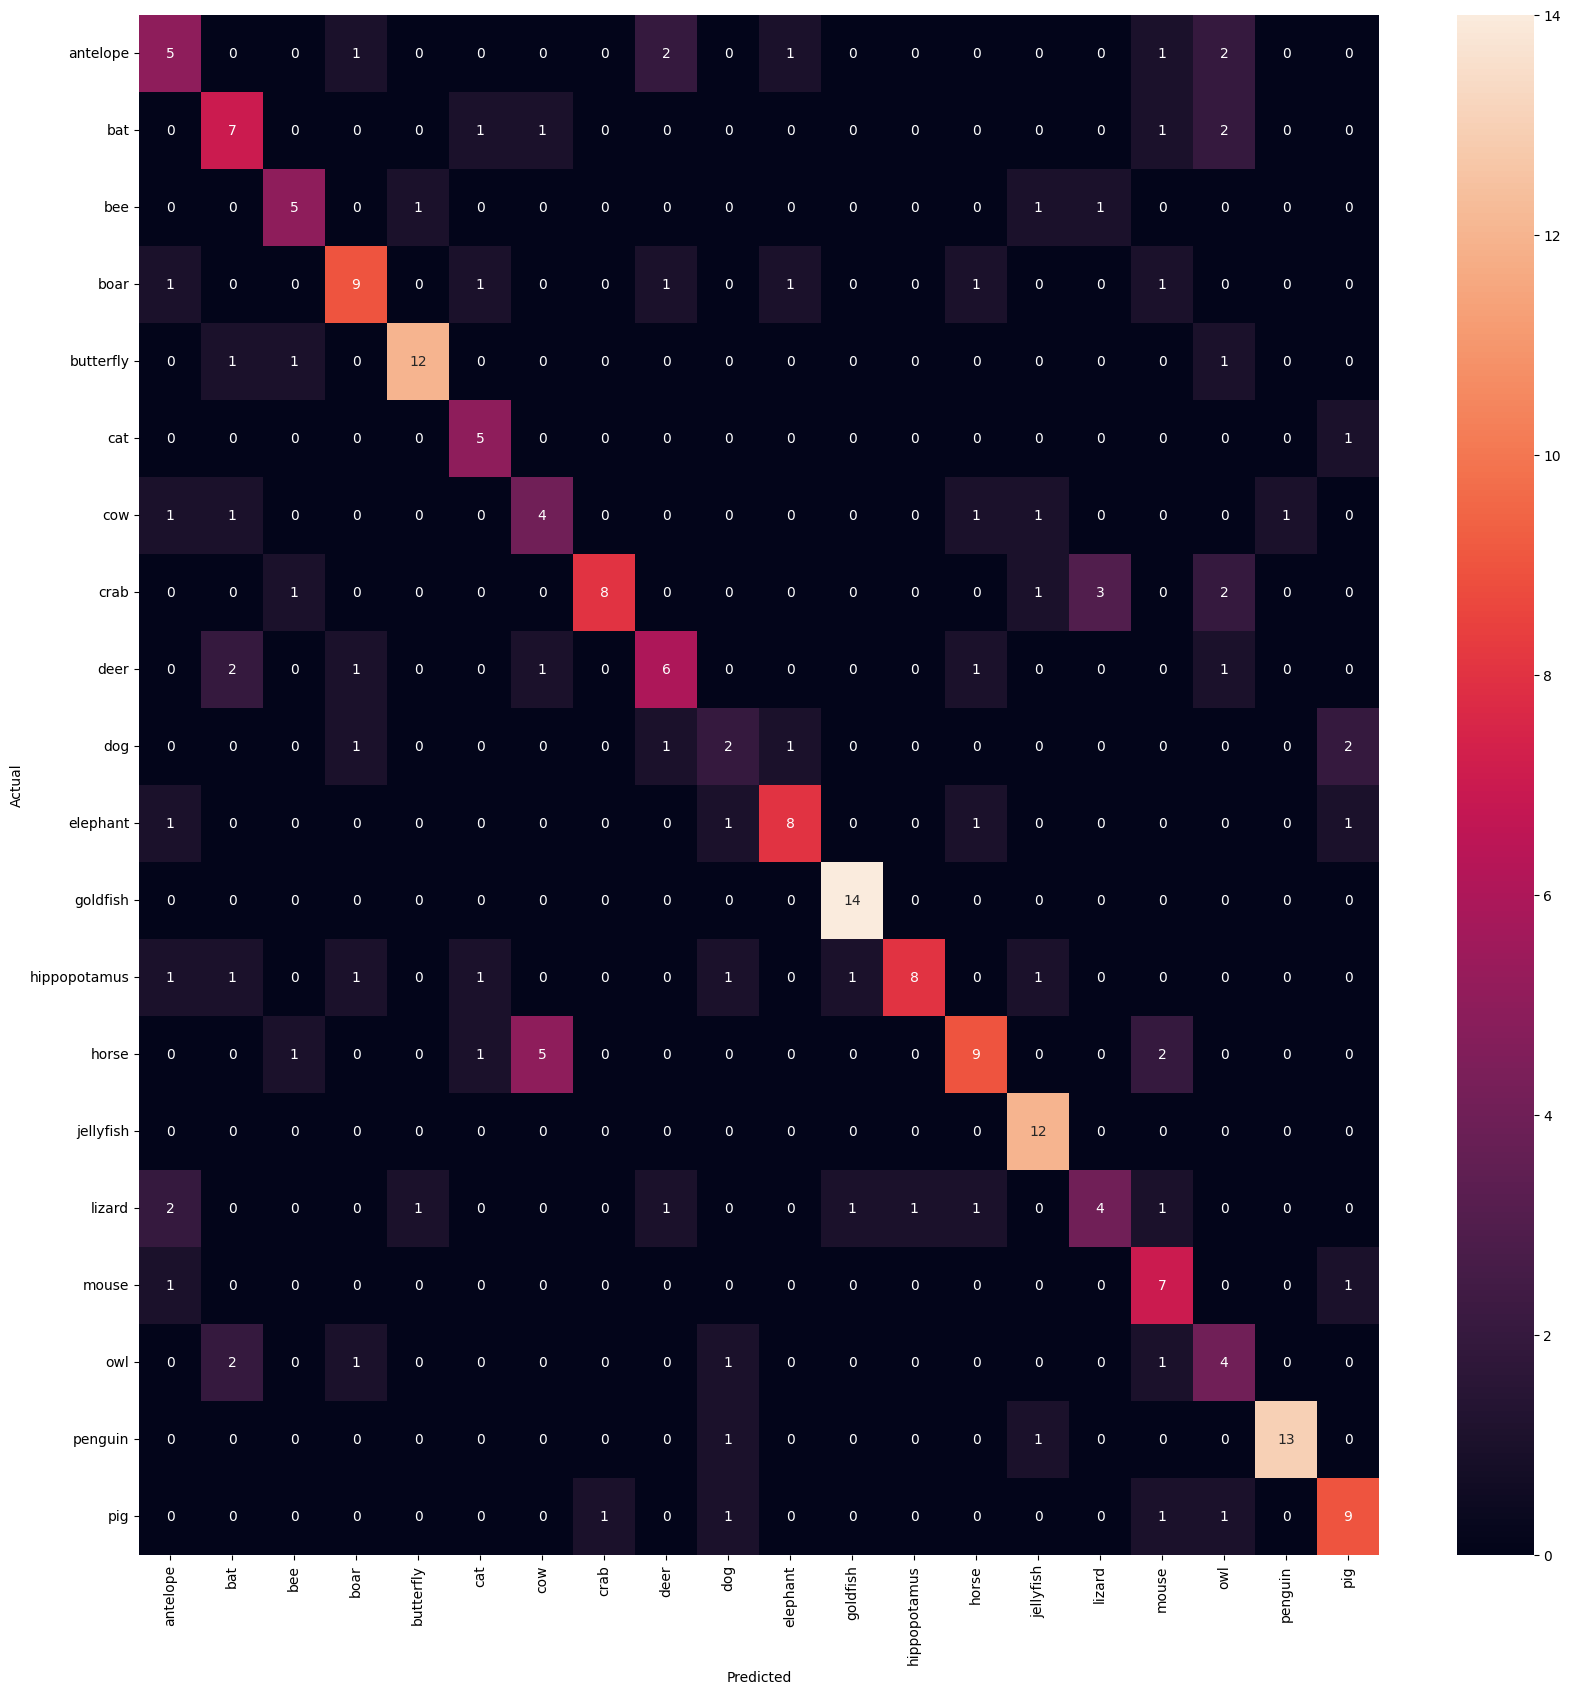

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)  # Changed to resnet
        _, preds = torch.max(outputs, 1)
        predlist = torch.cat([predlist, preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])

conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy())
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=test_dataset.dataset.classes,
            yticklabels=test_dataset.dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

resnet.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)  # Changed to resnet
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)

print(class_report)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


              precision    recall  f1-score   support

    antelope       0.42      0.42      0.42        12
         bat       0.50      0.58      0.54        12
         bee       0.62      0.62      0.62         8
        boar       0.64      0.60      0.62        15
   butterfly       0.86      0.80      0.83        15
         cat       0.56      0.83      0.67         6
         cow       0.36      0.44      0.40         9
        crab       0.89      0.53      0.67        15
        deer       0.55      0.50      0.52        12
         dog       0.29      0.29      0.29         7
    elephant       0.73      0.67      0.70        12
    goldfish       0.88      1.00      0.93        14
hippopotamus       0.89      0.53      0.67        15
       horse       0.64      0.50      0.56        18
   jellyfish       0.71      1.00      0.83        12
      lizard       0.50      0.33      0.40        12
       mouse       0.47      0.78      0.58         9
         owl       0.31    